In [1]:
#Q-learn zamiast SARSA
using ReinforcementLearningBase, ReinforcementLearningEnvironments
using Plots; gr(); 
import StatsBase.sample
env = MountainCarEnv();

In [2]:
tilling(S,n,offset) = [(i,j) for i in range(S[1].left + offset,S[1].right + offset, length = n + 1), 
        j in range(S[2].left + offset,S[2].right + offset, length = n + 1)] 

tillings(S,n,m) = [tilling(S,n,i/n) for i = 0:m-1]

between(x,a,b) = a ≤ x < b 

code(s,t::Array{Tuple{Float64,Float64},2}) = [between(s[1],t[i,j][1],t[i+1,j][1]) && between(s[2],t[i,j][2],t[i,j+1][2])
      for j = 1:size(t,2)-1 for i = 1:size(t,1)-1]

code(s,tillings::Array{Array{Tuple{Float64,Float64},2},1}) = 
                vcat([code(s,t) for t in tillings]...)

code (generic function with 2 methods)

In [3]:
mutable struct Agent
    env::AbstractEnv
    ϵ::Float64
    ϵ_decay::Float64
    ϵ_min::Float64
    β::Float64
    η::Float64
    tillings::Array{Array{Tuple{Float64,Float64},2},1}
    W::Array{Float64,2}
    position::Float64
    reward::Float64
end

Agent(env, n, m, ϵ = 1.0, ϵ_decay = 0.9975, 
    ϵ_min = 0.005, β = 0.99, η = 0.02) = Agent(env, ϵ, ϵ_decay, ϵ_min, β, η,
                                                tillings(state_space(env), n, m),
                                                rand(length(action_space(env)), n*n*m),
                                                -Inf, 0.0)

policy(agent::Agent, state) = argmax(agent.W * state)

policy (generic function with 1 method)

In [4]:
#wykorzystując algorytm SARSA
function step!(agent::Agent, train::Bool)
    s = code(deepcopy(state(agent.env)), agent.tillings)
    (rand() < agent.ϵ  && train) ? (a = rand(agent.env.action_space)) : (a = policy(agent, s))
    agent.env(a)
    r, s′, terminal = deepcopy(reward(agent.env)), deepcopy(state(agent.env)), deepcopy(is_terminated(agent.env))
    agent.position = s′[1]
    s′ = code(s′,agent.tillings)
    agent.reward += r
    if train
        if terminal
            R  = r
        else
            Q_new_state = agent.W * s′
            #Podążanie ϵ-greedy zamiast argmax
            (rand() < agent.ϵ  && train) ? (new_a = rand(agent.env.action_space)) : (new_a = argmax(agent.W * s′))
            R = r + agent.β * Q_new_state[new_a]
            
        end
        Q_hat = agent.W * s
        Q = deepcopy(Q_hat)
        Q[a] = R
        agent.W += agent.η*(Q .- Q_hat) * transpose(s)
    end
    terminal 
end

step! (generic function with 1 method)

In [5]:
function run!(agent::Agent, episodes::Int; train::Bool = true, plotting::Bool = true, summary::Bool = true)
    rewards = []
    success_rates = []
    ep = 1.0
    success = 0.0
    while ep ≤ episodes
        plotting && (plot(env); sleep(0.0001))
        if step!(agent, train) 
            reset!(agent.env)
            agent.position > 0.5 && (success += 1.0)
            push!(rewards, agent.reward)
            push!(success_rates, success/ep)
            if summary
                println("episode $(Int(ep)) ends! Reward: $(agent.reward)")
                println("ϵ: $(agent.ϵ), success rate: $(success/ep)")
            end
            ep += 1.0
            agent.reward = 0.0
            agent.position = -Inf
            eps = agent.ϵ * agent.ϵ_decay
            agent.ϵ = max(agent.ϵ_min, eps)
        end
    end
    return rewards, success_rates
end

run! (generic function with 1 method)

In [ ]:
agent = Agent(env,8,4);

#rewards,_ = run!(agent,10; train = false, plotting = true);

rewards, success_rates = run!(agent,5_000; plotting = false);

#Dla lepszej przejrzystości wstawiono wycinek wyników wskazujący na moment pierwszego sukcesu

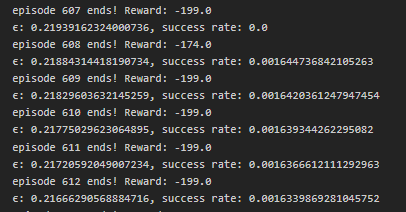

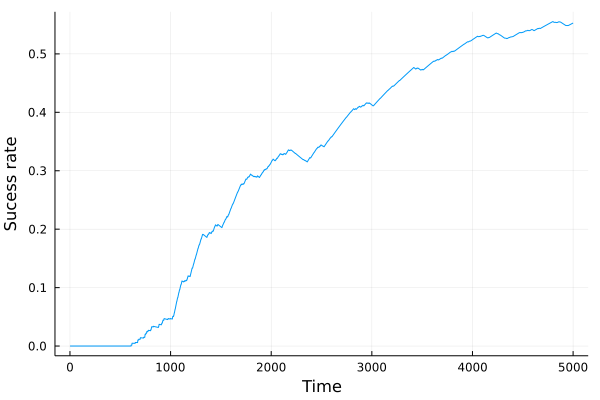

In [7]:
plot(success_rates, xlabel = "Time", ylabel = "Sucess rate", legend = false)

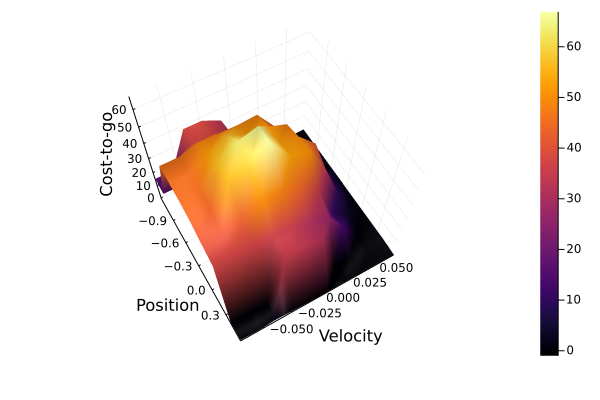

In [8]:
X = range(state_space(agent.env)[1].left,state_space(agent.env)[1].right,length = 10)
Y = range(state_space(agent.env)[2].left,state_space(agent.env)[2].right,length = 10)
Z = [maximum(agent.W * code((x,y),agent.tillings)) for x in X, y in Y];

plot(X,Y,-Z, st=:surface, camera = (60,60), xlabel = "Position", ylabel = "Velocity", zlabel = "Cost-to-go")

In [9]:
rewards,success_rates = run!(agent,1000; train = false, plotting = false, summary = false);

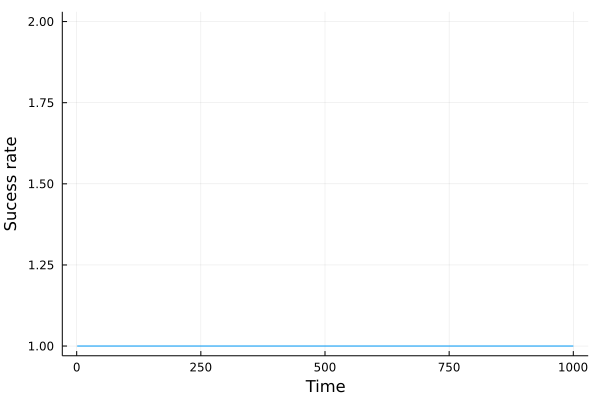

In [10]:
plot(success_rates, xlabel = "Time", ylabel = "Sucess rate", legend = false)

In [11]:
#wykorzystując algorytm Q-learning
function step!(agent::Agent, train::Bool)
    s = code(deepcopy(state(agent.env)), agent.tillings)
    (rand() < agent.ϵ  && train) ? (a = rand(agent.env.action_space)) : (a = policy(agent, s))
    agent.env(a)
    r, s′, terminal = deepcopy(reward(agent.env)), deepcopy(state(agent.env)), deepcopy(is_terminated(agent.env))
    agent.position = s′[1]
    s′ = code(s′,agent.tillings)
    agent.reward += r
    if train
        if terminal
            R  = r
        else
            Q_new_state = agent.W * s′
            #Podążanie ϵ-greedy zamiast argmax
            R = r + agent.β * Q_new_state[policy(agent,s′)]
           

        end
        Q_hat = agent.W * s
        Q = deepcopy(Q_hat)
        Q[a] = R
        agent.W += agent.η*(Q .- Q_hat) * transpose(s)
    end
    terminal 
end

step! (generic function with 1 method)

In [ ]:
agent = Agent(env,8,4);

rewards, success_rates = run!(agent,5_000; plotting = false);

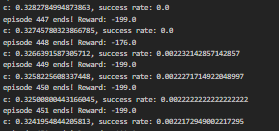

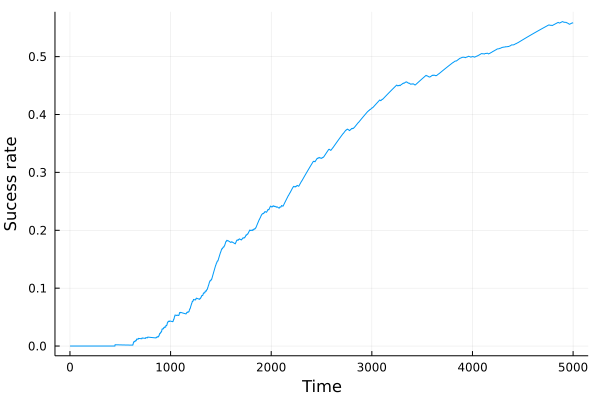

In [13]:
plot(success_rates, xlabel = "Time", ylabel = "Sucess rate", legend = false)

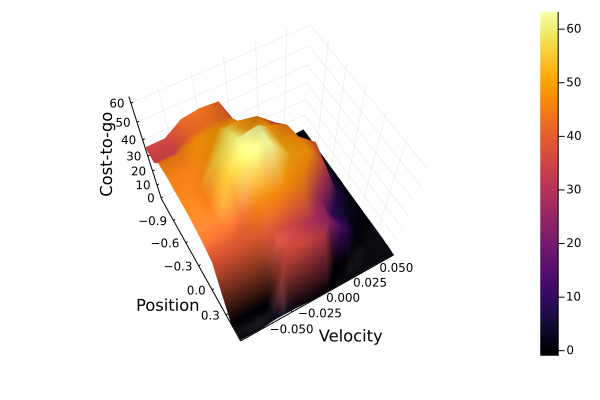

In [14]:
X = range(state_space(agent.env)[1].left,state_space(agent.env)[1].right,length = 10)
Y = range(state_space(agent.env)[2].left,state_space(agent.env)[2].right,length = 10)
Z = [maximum(agent.W * code((x,y),agent.tillings)) for x in X, y in Y];

plot(X,Y,-Z, st=:surface, camera = (60,60), xlabel = "Position", ylabel = "Velocity", zlabel = "Cost-to-go")

In [15]:
rewards,success_rates = run!(agent,1000; train = false, plotting = false, summary = false);

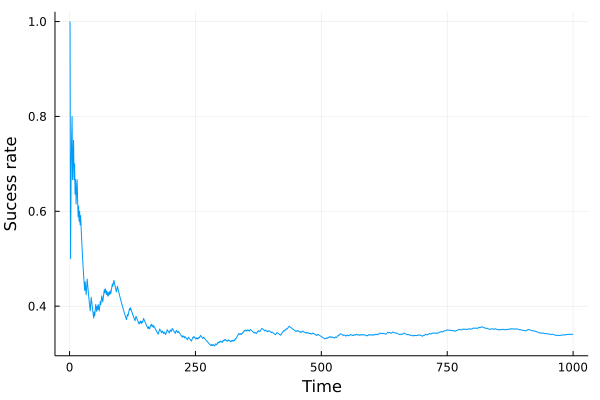

In [16]:
plot(success_rates, xlabel = "Time", ylabel = "Sucess rate", legend = false)

In [17]:
#Algorytm SARSA wyznacza skumulowaną nagrodę na podstawie epizodu wygenerowanego według przyjętej
#reguły,traktujac aktualny punkt jak element łańcucha. Wraz ze spadkiem parametru ekploracji algorytm 
#coraz częściej opiera obliczoną skumulowaną nagrodę o serie chciwych wyborów akcji.
#W konsekwencji zbiega do rozwiązania wykonującego same chciwe akcje (końcową strategię).
#W powyższym eksperymencie algorytm sarsa doprowadził do powstania rozwiązania,
#które regularnie pokonuje postawione zadanie. 

#Algorytm Q-learning ustala pierwszą akcję na podsatwie zasad (np. ϵ-greedy),
#a następnie zbiera skumulowaną nagrodę dla kolejnych chciwych akcji.
#W ten sposób zbiera możliwie dużą nagrode skumulowaną, znacznie tracąc na ekploracji.
#W toku ekperymentu rozwiązanie zdołało wypracować strategie która przynosi pozytywne rezultaty.
#W przypadku Q-learningu ekploracja dotyczy pojedynczych stanów na cały epizod 
#(co wyraźnie spowalnia proces uczenia). 

#Algorytm Q-learning jest specjalnym przypadkiem algorytmu SARSA. Eksperyment pokazał, że algorytm
# SARSA wypracowało strategię pozwalającą na pewne przechodzenie środowiska,
#natomiast algorytm Q-learning osiąga strategię suboptymalną uzyskującą pozytywne rezultaty,
#ale ze znacznie mniejszą czestotliwością stablizując się na poziomie ~35% sukcesów.